In [12]:
#Imports

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import pandas as pd
import numpy as np

In [ ]:
#For each input (x,y,z) make q circuit with 3 qubits, 3 classical registers
# measure in x basis if input is 0, y basis if input is 1

def GHZ_circuit(x:int,y:int,z:int):
    qc = QuantumCircuit(3,3)
    qc.h(0)
    qc.cx(0,1)
    qc.cx(1,2)
    qc.barrier()

    inputs = [x,y,z]
    for qbit, inp in enumerate(inputs):
        if inp == 0:
            qc.h(qbit)
        else:
            qc.sdg(qbit) ; qc.h(qbit)
            
    qc.measure([0,1,2],[0,1,2])

    return qc

In [10]:
#OPTIONAL check with state vector if state matches GHZ state so i know i didnt mess up something yet, also no measurments!
from qiskit.quantum_info import Statevector

sv = Statevector.from_label('000') 
print("φ0 amplitudes:", sv.data)

#φ1 = (H⊗I⊗I) φ0
step = QuantumCircuit(3); step.h(0)
sv = sv.evolve(step)               # evolve by the tiny circuit
print("φ1:", sv.data)

#φ2 =(CX⊗I)
step = QuantumCircuit(3); step.cx(0, 1)
sv = sv.evolve(step)
print("φ2:", sv.data)

#φ3 = (I⊗CX
step = QuantumCircuit(3); step.cx(1,2)
sv = sv.evolve(step)
print("φ3:", sv.data)

print("Exact probs of phi3:", np.abs(sv.data)**2)

φ0 amplitudes: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
φ1: [0.70710678+0.j 0.70710678+0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
φ2: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
φ3: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Exact probs of phi3: [0.5 0.  0.  0.  0.  0.  0.  0.5]


In [14]:
def estimate_win_proba(x:int,y:int,z:int, shots: int = 20000, backend: AerSimulator = None):
    if backend is None:
        backend = AerSimulator(method='statevector', shots=shots)

    qc = GHZ_circuit(x,y,z)
    transpiled_qc = transpile(qc, backend)
    result = backend.run(transpiled_qc, shots=shots).result()
    counts = result.get_counts()
    
    target = int(bool(x or y or z)) # 1 if any of x,y,z is 1, else 0
    win_counts = 0
    total = 0

    for bitst, cnt in counts.items():
        a = int(bitst[2]) 
        b = int(bitst[1])
        c = int(bitst[0]) # bitst is in reverse order
        if (a ^ b ^ c) == target:
            win_counts += cnt
        total += cnt
    p_win = win_counts / total
    
    return p_win, counts, transpiled_qc

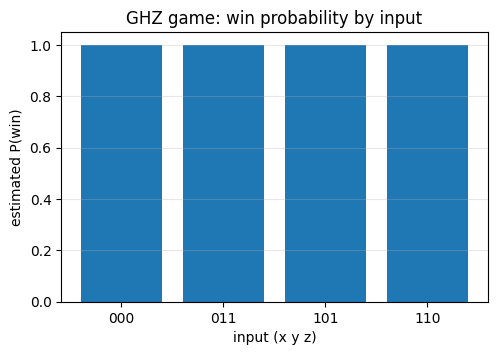

In [17]:
import matplotlib.pyplot as plt

promised_inputs = [(0,0,0), (0,1,1), (1,0,1), (1,1,0)]
data = []

for (x, y, z) in promised_inputs:
    p_win, counts, qc = estimate_win_proba(x,y,z)
    data.append({
        "input": f"{x}{y}{z}", 
        "counts": counts,
        "OR(x,y,z)": int(bool(x or y or z)),
        "p_win": p_win,
        })
df= pd.DataFrame(data)

plt.figure(figsize=(5.5,3.5))
plt.bar(df["input"], df["p_win"])
plt.xlabel("input (x y z)")
plt.ylabel("estimated P(win)")
plt.title("GHZ game: win probability by input")
plt.grid(axis="y", alpha=0.3)
plt.show()
    
